# Barton Springs Salamanders & Watershed Quality Report
### Benjamin Goad, Michelle Gelman, Nick Hoang, Daphne Lopez

##### Import libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,date as dt
import sklearn as sk
import random
from sklearn.manifold import MDS



## Summary of data set
In out project we explored how water quality impacted salamander populations across different springs in the austin area. The Dataset is managed by Austintexas.gov. The data has been collected over a number of years from 1993 to 2015. Spring sites were tested to collect various samples such as flow rate, salamander sitings, and oxygen content. Our data set contained datapoints that represent measurements taken from the water samples. 

### Data Prep
Read in the data set and print out the head. Key features are PARAM_TYPE, which describes what is being measured; PARAMETER and RESULT describe the measurement itself.
We also want to note date the sample was taken and the site it was taken at, to find trends over the number of years.

In [17]:
rawData  = pd.DataFrame(pd.read_csv("Barton_Springs_Salamanders_DO_and_Flow.csv"))
rawData.head(1000)

/home/user/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,WATERSHED,SAMPLE_DATE,SITE_NAME,LON_DD_WGS84,LAT_DD_WGS84,SITE_TYPE,MEDIUM,PARAM_TYPE,PARAMETER,QUALIFIER,...,FILTER,SAMPLE_ID,SAMPLE_SITE_NO,METHOD,QC_FLAG,PROJECT,DATA_REF_NO,SAMPLE_REF_NO,TIME_NULL,QC_TYPE
0,Barton Creek,07/06/1990 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,UNKNOWN,U,Water Watch Dog,2387519,479314,Y,NaN
1,Barton Creek,07/01/1991 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,HACH TEST KIT,U,Water Watch Dog,1053022,67681,Y,NaN
2,Barton Creek,08/02/1991 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,HACH TEST KIT,U,Water Watch Dog,557211,67682,Y,NaN
3,Barton Creek,10/11/1991 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,HACH TEST KIT,U,Water Watch Dog,1052978,67677,Y,NaN
4,Barton Creek,06/04/1992 11:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,UNKNOWN,U,Water Watch Dog,2335102,450308,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,AUSTIN BLIND SLMNDR (<1IN.) (JUVENILE),NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1705157,342910,Y,NaN
996,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,AUSTIN BLIND SALMNDR (ADULT) > 1 INCH,NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1705158,342910,Y,NaN
997,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,SALAMANDER (UNKNOWN LENGTH),NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1680711,342910,Y,NaN
998,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,AUSTIN BLIND SALAMANDER (UNKNOWN LENGTH),NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1705163,342910,Y,NaN


## Feature Engineering Plan
- [ ] aggregate sample IDS by parameter types:
    - [ ] get result and unit for each paramater type
    - [ ] do cleanintg for null values
    - [ ] print out a scatter plot for each paratamer_type(check for outliers before normalizing)
    - [ ] print out statistics on each (std, mean, var -> maybe add each as a new column)
    - [ ] groupBy time_null-> see how many records dont have a date. do a time series plot for result + time for each salamander parameter
## What data might we need?
 - how do we condiser the other paramater types? We could maybe see the days when samples were collected, and add salamander paramater as a new feature. Groupby site name?
 - how do salamander poplations vary at different types?
 - what paramater types have a (+/-) correlation with salamnder populations?
 - do any of the paramater types have an affect on the salamnder sizes? does the season explain it, or is it something about the paramater type at that site?
 - maybe we could get a data set with mineral content or weather data? what about water levels?
- [ ] Don't need qualifier, sample IDs, filter, don't need sample_id, sample_site_no, 


In [18]:
def param_parser(row):
    surfaces = ['VEGETATION/MOSS', 'COBBLE/BOULDER', 'EXPOSED', "LEAF LITTER"]
    new_cols = {"SALAMANDER": 0, "SIZE": 0, "SURFACE": 0}

        
    size_idx_2 = row.find(str(2))
    size_idx_1 = row.find(str(1))

    if size_idx_1 == -1:
        new_cols["SIZE"] = 2

    elif size_idx_1 != -1 and size_idx_2 != -1:
            new_cols["SIZE"] = 1.5
    else:
        new_cols["SIZE"] = 1

    if size_idx_1 == -1 and size_idx_2 == -1:
        return [0, 0, ""]

    surface_idx = -1

    for surface in surfaces:
        surface_idx = row.find(surface)
        if surface_idx != -1:
            surface_str = row[surface_idx:]
            new_cols["SURFACE"] = surface_str
            break

    if (surface_idx == -1):
        return [0,0,""]


    if row[0:1] == 'A':
        new_cols["SALAMANDER"] = 0
    else:
        new_cols["SALAMANDER"] = 1

    
    return list(new_cols.values())

## Data Preprocessing

To prepare out data, we wanted to understand out features better. We noticed the PARAM_TYPE column had different methods to input the salamander samples that changed over the years and started including size theshold for each salamander sample.

We wanted the data to be uniform for this feature, so we broke up the size, salamander species, and sufarce into 3 seperate features for each datapoint. Upon examining the water features, we were most interested in the dissolved oxygen levels in each site, as other metrics had many unknown values or outliers; another thing we noticed is that certain years early on did not collect flow rates or other type of water sampling methods, so we chose to ignore these features in preparing our data set as they there statistically insignifacnt and noisy. This increased the quality of our data set, as we were able to get better predcitions in our models discussed later.

We grouped our data by the site types and found trends for various features over the years. Interestly when we examined the counts and oxygne levels, we found that thr Eliza springs site had the highest number of salamanders. This aligns with obsrvations, as Eliza Springs is the prime location for both the of the engangered salamander species and where active efforts to resore the water pool to the spring have been made.[Read the article here](http://austindowntowndiary.com/nature/barton-springs/). Most other pools had a realtively normal distirbution that was quite low compared to eliza springs throughout the years, and you can notice the delcind in populaiton especially in eliza springs from the bell curve shape of the counts.

 

![See the sign here](http://austindowntowndiary.com/wp-content/uploads/2016/01/DSC05922.jpg)

 

Beyond the salamnder, counts, we wanted to see how the salamander sizes varies by sites, and if there were any correlaitions between the sizes and oxyegen levels. We examined the mean trends for the various years at each site, and looked at the aggregate statictics for the sizes and oxygen levels for all years the data was collected. Oxygen levels varied over the years, but there seemed to be a higher number of salamnder sightigs when the average dissolved oxygen

 

In [19]:

# Austin sal is 0
# Barton sal is 1

data = rawData.copy()
data.drop(columns= ["LON_DD_WGS84","LAT_DD_WGS84","DATA_REF_NO","PROJECT", "QC_FLAG", "QC_TYPE", "SITE_TYPE", "SAMPLE_ID", "WATERSHED", "SAMPLE_SITE_NO", "QUALIFIER", "SAMPLE_REF_NO", "METHOD", "TIME_NULL" ], inplace=True)

data["SAMPLE_DATE"] = data["SAMPLE_DATE"].map(lambda x: x.split(" ")[0])
data["SAMPLE_DATE"] = data["SAMPLE_DATE"].map(lambda x: x.split("/")[0] + "/" + x.split("/")[2])
data["SAMPLE_DATA_NAME"] = data.SAMPLE_DATE + " " + data.SITE_NAME

sal_data = data.loc[data["PARAM_TYPE"] == "Salamanders"]
sal_data.head()

for idx , row in sal_data.iterrows():
    new_vals = param_parser(row["PARAMETER"])
    sal_data.loc[idx, "SALAMANDERS"] = new_vals[0]
    sal_data.loc[idx, "SIZE"] = new_vals[1]
    sal_data.loc[idx, "SURFACE"] = new_vals[2]



/usr/lib/python3/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
grouped_sal = sal_data.copy()
grouped_sal.drop(["MEDIUM", "UNIT", "FILTER"], axis=1, inplace=True)
grouped_sal = grouped_sal.groupby(["SAMPLE_DATA_NAME", "SAMPLE_DATE", "SITE_NAME", "PARAMETER", "SALAMANDERS", "SIZE", "SURFACE"], as_index=False)
summed_group = grouped_sal.sum()
summed_group = summed_group[summed_group["SURFACE"] != ""].dropna()


o2 = data[data["PARAM_TYPE"] == "Oxygen"]
o2 = o2[o2["UNIT"] != "(%) Percent"]
o2 = o2.groupby(["SAMPLE_DATA_NAME"], as_index=False)
for index, row in o2.mean().iterrows():
    summed_group.loc[summed_group["SAMPLE_DATA_NAME"] == row["SAMPLE_DATA_NAME"], "DISSOLVED_OXYGEN"] = row["RESULT"]

summed_group.fillna(method="ffill", inplace=True)

display(summed_group)


,SAMPLE_DATA_NAME,SAMPLE_DATE,SITE_NAME,PARAMETER,SALAMANDERS,SIZE,SURFACE,RESULT,DISSOLVED_OXYGEN
123,01/2004 Barton Spring,01/2004,Barton Spring,BARTON SPRINGS SLMNDR (<1IN.) IN COBBLE/BOULDER,1.0,1.0,COBBLE/BOULDER,68.0,6.26
134,01/2004 Eliza Spring,01/2004,Eliza Spring,BARTON SPRINGS SLMNDR (1-2IN.) IN COBBLE/BOULDER,1.0,1.5,COBBLE/BOULDER,124.0,6.12
135,01/2004 Eliza Spring,01/2004,Eliza Spring,BARTON SPRINGS SLMNDR (<1IN.) IN COBBLE/BOULDER,1.0,1.0,COBBLE/BOULDER,91.0,6.12
136,01/2004 Eliza Spring,01/2004,Eliza Spring,BARTON SPRINGS SLMNDR (>=2IN.) IN COBBLE/BOULDER,1.0,2.0,COBBLE/BOULDER,16.0,6.12
142,01/2004 Old Mill (Sunken Gardens) Spring,01/2004,Old Mill (Sunken Gardens) Spring,AUSTIN BLIND SLMNDR (1- 2IN.) IN VEGETATION/MOSS,0.0,1.5,VEGETATION/MOSS,1.0,6.25
...,...,...,...,...,...,...,...,...,...
9591,12/2013 Upper Barton Spring,12/2013,Upper Barton Spring,BARTON SPRINGS SLMNDR (<1IN.) ON EXPOSED SUBST...,1.0,1.0,EXPOSED SUBSTRATE,0.0,5.68
9592,12/2013 Upper Barton Spring,12/2013,Upper Barton Spring,BARTON SPRINGS SLMNDR (>=2IN.) IN COBBLE/BOULDER,1.0,2.0,COBBLE/BOULDER,1.0,5.68
9593,12/2013 Upper Barton Spring,12/2013,Upper Barton Spring,BARTON SPRINGS SLMNDR (>=2IN.) IN LEAF LITTER,1.0,2.0,LEAF LITTER,0.0,5.68
9594,12/2013 Upper Barton Spring,12/2013,Upper Barton Spring,BARTON SPRINGS SLMNDR (>=2IN.) IN VEGETATION/MOSS,1.0,2.0,VEGETATION/MOSS,1.0,5.68


## Data Patterns 
In our data set, when plotting the counts of salamander against the dissolved oxygen content, we saw a normal distribution centered on about 5.8 MG/L for all sites except Upper barton springs. Here, the oxygen content was centered slightly higher at 7.2 MG/L. We hypothesized that this might be caused by greater temperature fluctuations in upper barton springs where the water is shallower, leading to change in oxygen saturation 


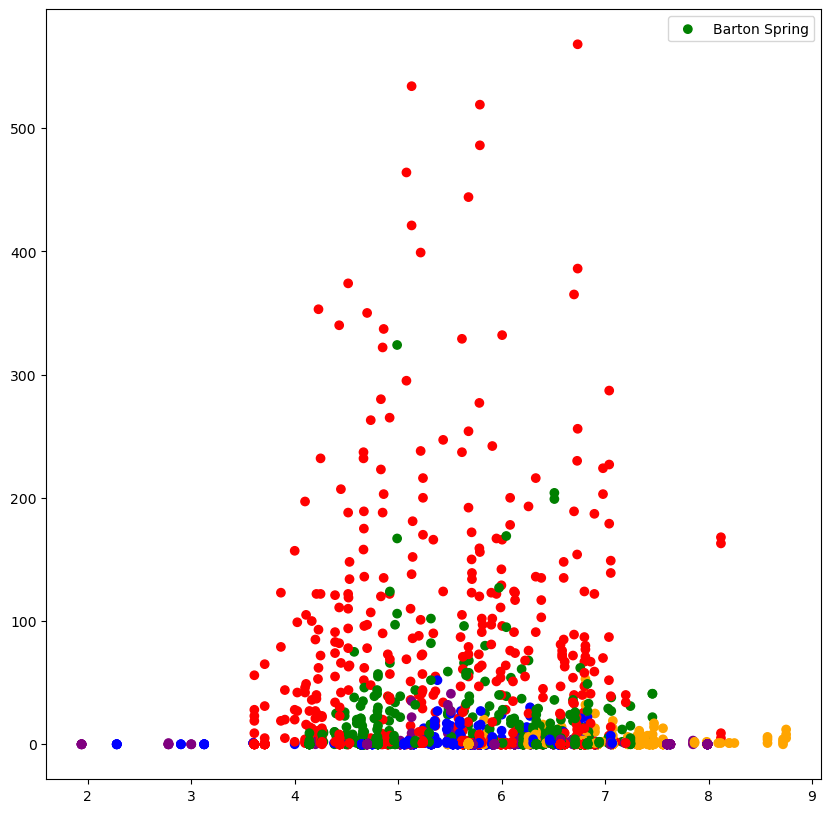

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [10]:
df = summed_group.copy()
df = df[df["DISSOLVED_OXYGEN"] < 10]

colors = {"Eliza Spring": "red", "Old Mill (Sunken Gardens) Spring": "blue", "Barton Spring": "green", "Old Mill Stream (outflow from Sunken Gardens Pool)": "purple", "Upper Barton Spring": "orange"}
sites = df["SITE_NAME"].unique()

plt.figure(figsize=(10, 10))
# for idx, row in df.iterrows():
#     plt.scatter(row["DISSOLVED_OXYGEN"], row["RESULT"], c=colors[row["SITE_NAME"]])
plt.scatter(df["DISSOLVED_OXYGEN"], df["RESULT"], c=df["SITE_NAME"].map(lambda x: colors[x]))
plt.legend(sites)
# plt.scatter(df["DISSOLVED_OXYGEN"], df["RESULT"], c=colors[df["SITE_NAME"]])
plt.show()
plt.figure(figsize=(10, 10))



{'Eliza Spring': 'red', 'Old Mill (Sunken Gardens) Spring': 'blue', 'Barton Spring': 'green', 'Old Mill Stream (outflow from Sunken Gardens Pool)': 'purple', 'Upper Barton Spring': 'orange'}


/usr/lib/python3/dist-packages/pandas/core/frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


DISSOLVED_OXYGEN            \
YEAR                                                           2002      2003   
SITE_NAME                                                                       
Barton Spring                                              6.787500  6.679222   
Eliza Spring                                               6.152333  6.218433   
Old Mill (Sunken Gardens) Spring                           6.025417  5.928152   
Old Mill Stream (outflow from Sunken Gardens Pool)              NaN       NaN   
Upper Barton Spring                                             NaN  7.719698   

                                                                        \
YEAR                                                    2004      2005   
SITE_NAME                                                                
Barton Spring                                       6.200178  6.197381   
Eliza Spring                                        5.812473  6.007465   
Old Mill (Sunken Gardens) Spring                    5.847369  6.136364   
Old Mill Stream (outflow from Sunken Gardens Pool)       NaN  6.472500   
Upper Barton Spring                                 6.517396  7.622500   

                                                                        \
YEAR                                                    2006      2007   
SITE_NAME                                                                
Barton Spring                                       4.993804  6.515283   
Eliza Spring                                        4.802222  6.405326   
Old Mill (Sunken Gardens) Spring                    4.048148  5.862247   
Old Mill Stream (outflow from Sunken Gardens Pool)  3.600000  6.379000   
Upper Barton Spring                                      NaN  6.875000   

                                                                        \
YEAR                                                    2008      2009   
SITE_NAME                                                                
Barton Spring                                       5.557556  5.860409   
Eliza Spring                                        5.308438  4.546617   
Old Mill (Sunken Gardens) Spring                    4.732250  6.109643   
Old Mill Stream (outflow from Sunken Gardens Pool)  4.620244  7.190000   
Upper Barton Spring                                 6.500625  7.076000   

                                                                        \
YEAR                                                    2010      2011   
SITE_NAME                                                                
Barton Spring                                       5.835544  4.946441   
Eliza Spring                                        6.522791  4.857422   
Old Mill (Sunken Gardens) Spring                    5.683000  6.011795   
Old Mill Stream (outflow from Sunken Gardens Pool)  5.788182  6.044286   
Upper Barton Spring                                 7.245208  7.245000   

                                                                        \
YEAR                                                    2012      2013   
SITE_NAME                                                                
Barton Spring                                       6.459702  4.586378   
Eliza Spring                                        5.870511  4.763232   
Old Mill (Sunken Gardens) Spring                    5.827805  3.775000   
Old Mill Stream (outflow from Sunken Gardens Pool)  6.522500  4.252941   
Upper Barton Spring                                 6.777000  5.680000   

                                                                    
YEAR                                                    2014  2015  
SITE_NAME                                                           
Barton Spring                                       5.930667  5.98  
Eliza Spring                                        6.032476   NaN  
Old Mill (Sunken Gardens) Spring                    5.700000  6.13  
Old Mill Stream (outflo

SALAMANDERS      SIZE     RESULT  DISSOLVED_OXYGEN
SITE_NAME           YEAR                                                    
Barton Spring       2002     0.750000  1.000000  13.250000          6.787500
                    2003     0.666667  1.000000  10.833333          6.679222
                    2004     0.956522  1.369565  11.652174          6.200178
                    2005     1.000000  1.500000  36.095238          6.197381
                    2006     0.913043  1.413043  34.478261          4.993804
...                               ...       ...        ...               ...
Upper Barton Spring 2011     0.500000  1.500000   0.458333          7.245000
                    2012     0.542857  1.500000   1.333333          6.777000
                    2013     0.500000  1.500000   0.125000          5.680000
                    2014     1.000000  1.000000   1.000000          4.500000
                    2015     0.500000  1.500000   0.000000          7.430000

[63 rows x 4 columns]

/usr/lib/python3/dist-packages/pandas/core/frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,DISSOLVED_OXYGEN,SIZE,RESULT
SITE_NAME,,,
Barton Spring,5.710640,1.468254,9.509524
Eliza Spring,5.621343,1.489205,37.531818
Old Mill (Sunken Gardens) Spring,5.782012,1.467586,1.495172
Old Mill Stream (outflow from Sunken Gardens Pool),5.935835,1.502114,0.632135
Upper Barton Spring,6.935951,1.502597,1.740260


/usr/lib/python3/dist-packages/pandas/core/frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,DISSOLVED_OXYGEN,SIZE,RESULT
SURFACE,,,
COBBLE/BOULDER,5.796689,1.485159,28.267845
EXPOSED SUBSTRATE,5.989893,1.484909,0.062374
LEAF LITTER,5.995455,1.497012,0.129482
VEGETATION/MOSS,5.928461,1.469072,1.438881


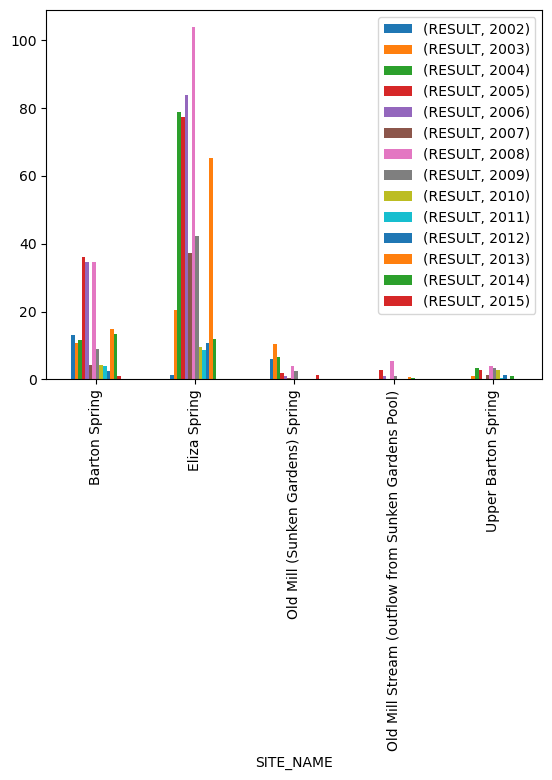

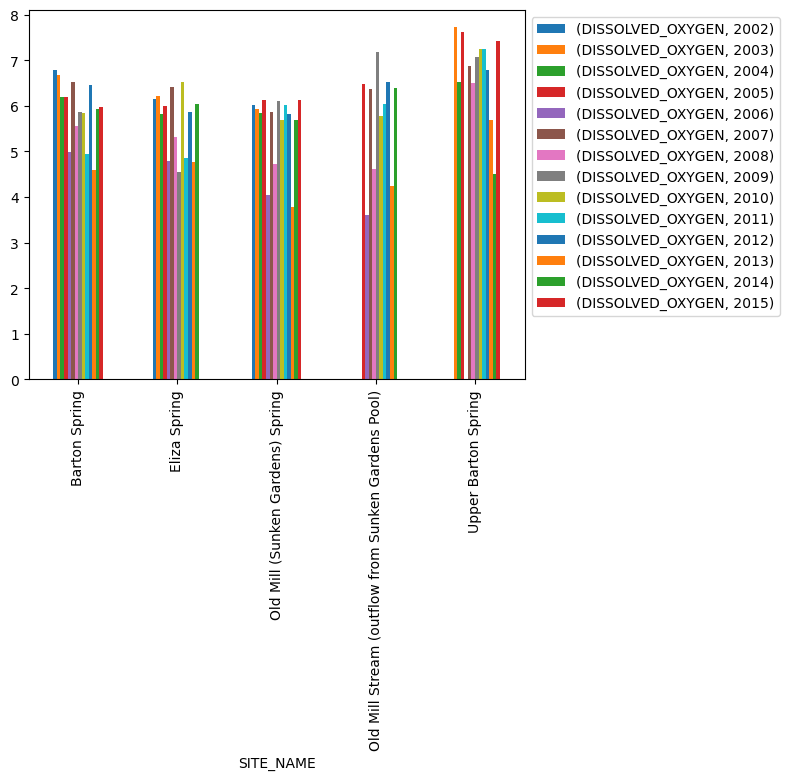

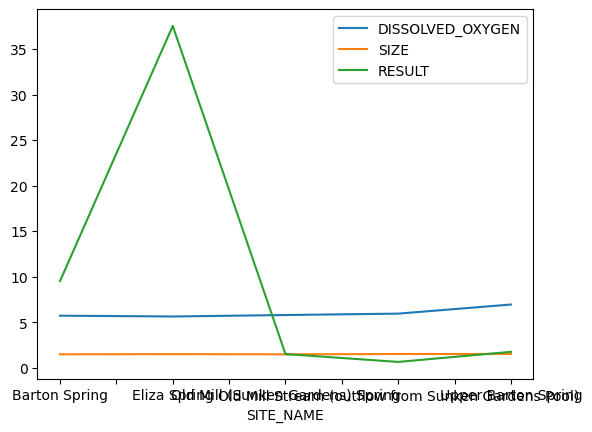

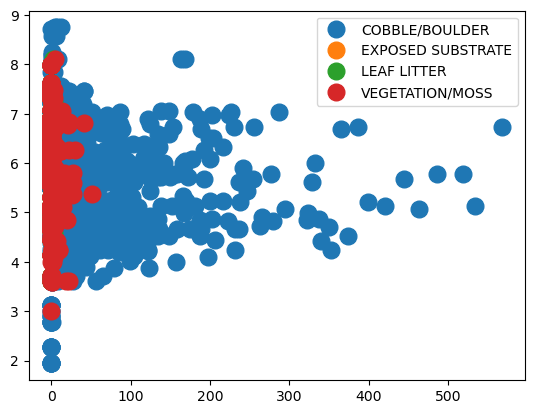

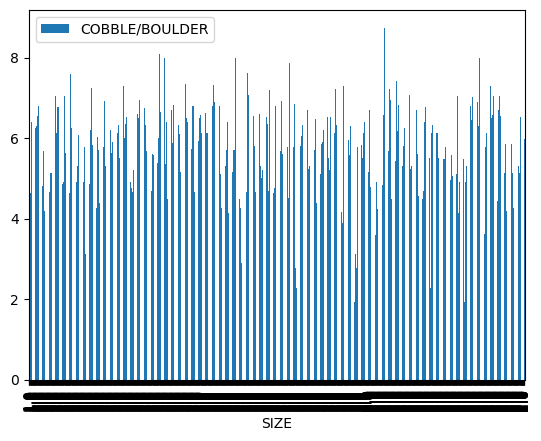

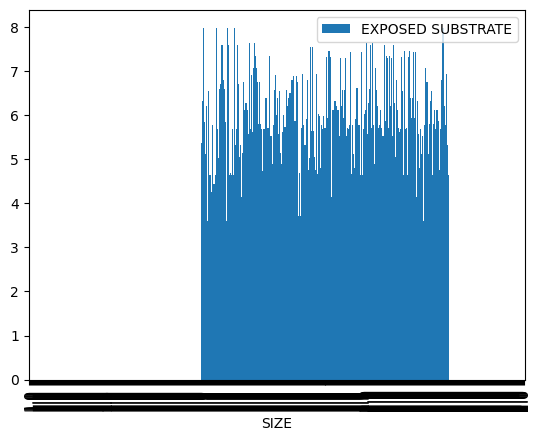

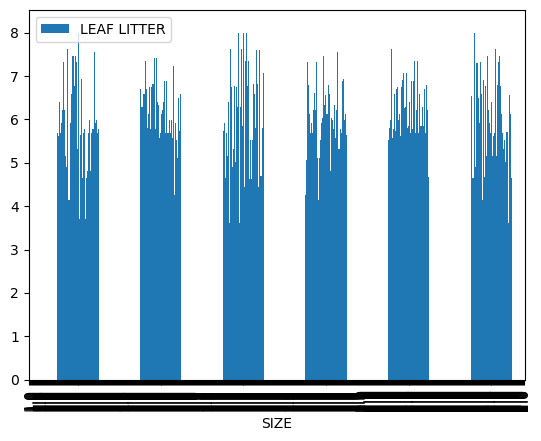

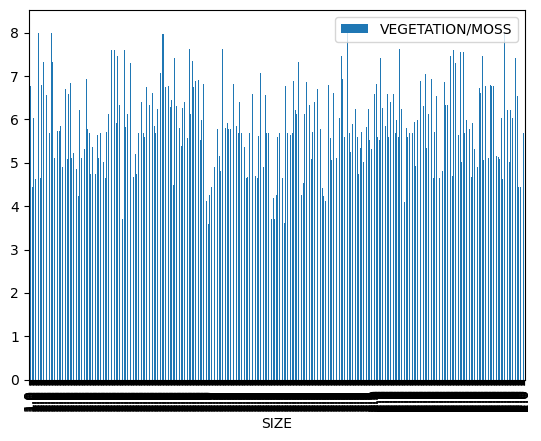

In [21]:
print(colors)

 

date_format = pd.DatetimeIndex(df["SAMPLE_DATE"])

df["YEAR"] = date_format.year

 

df = df.sort_values(by = "YEAR")

 

grouped_sites = df.groupby(["SITE_NAME", "YEAR"])

grouped_means = grouped_sites.mean()

grouped_sites.fillna(method="ffill", inplace=True)

grouped_means_sal_counts = grouped_sites[["RESULT"]].mean().unstack('YEAR')

grouped_means_sal_counts.plot(kind="bar").legend(bbox_to_anchor=(1.0, 1.0))

 

grouped_means_sal_counts = grouped_sites[["DISSOLVED_OXYGEN"]].mean().unstack('YEAR')

grouped_means_sal_counts.plot(kind="bar").legend(bbox_to_anchor=(1.0, 1.0))

 

 

display(grouped_means_sal_counts)

display(grouped_means)

 

# plt.figure(figsize=(10, 10))

# plt.scatter(df["YEAR"], df["RESULT"], c=df["SITE_NAME"].map(lambda x: colors[x]))

# plt.show()

 

grouped_res = df.groupby(["SITE_NAME"])

grouped_res.fillna(method="ffill", inplace=True)

grouped_res_means = grouped_res[["DISSOLVED_OXYGEN", "SIZE", "RESULT"]].mean()

grouped_res_means.plot()

display(grouped_res)

display(grouped_res_means)

 

#group by surface type

grouped_res = df.groupby(["SURFACE"])

grouped_res.fillna(method="ffill", inplace=True)

grouped_res_means_size = grouped_res[["DISSOLVED_OXYGEN", "SIZE", "RESULT"]].mean()

#grouped_res_means_size.plot.bar(x=)

display(grouped_res_means_size)

 

 

fig, ax = plt.subplots()

ax.margins(0.05)

for name, group in grouped_res:

    group =group.sort_values(by= 'SIZE')

    ax.plot(group.RESULT, group.DISSOLVED_OXYGEN, marker='o', linestyle='', ms=12, label=name)

    group.plot.bar(x='SIZE', y='DISSOLVED_OXYGEN', label=name)

ax.legend(bbox_to_anchor=(1.0, 1.0))

plt.show()

## Models
# Modeling Assessment

We used both k-means clustering and decision trees for our models. We chose to use k-means because we interesting relationships between the features we were unable to spot. However, we did not get many useful metrics out of clustering, as the sillouette score was quite low and the clustering was ambiguous as we weren't sure how the sites correlated with one another. Our decision tree model performed better-- we numerically encoded the surface values and tried to predict the best hyperparameters and see how well we could predict salamander counts given features about the site, dissolved water quality, and other natural features. We used cross-validation and built a final model with an accuracy of 61%; we think this was a fair indication of the salamander populations based on out features.

We then wanted to see the test for correctly predicting type of salamander based on given features. We build a confusion matrix to summarize our findings and achieved a higher recall for our model with lower precision. We were able to correctly predict a high number of true positives for our expected salamander species. 

Overall, our models were indicitave of the trends we found in the data for lower salamander sightings at the various sights as well as its slight correlaion to higher dissolved oxgen levels as it was chosen as one of the best features to split on in terms of predicting the species. 


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#k-means for oxygen and salamder counts

#one-hot encoding for surface
pca_df = pd.get_dummies(df, columns= ["SURFACE"])

pca_df.drop(["SAMPLE_DATA_NAME", "PARAMETER", "SITE_NAME", "SAMPLE_DATE"], axis= 1, inplace=True)
# Remove categorical columns and pca reduction
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_df)
pca = PCA(n_components=.95,svd_solver ="full")
pca_data = pca.fit_transform(scaled_data)
df_data = pd.DataFrame(pca_data)
#df_data.head()



#PCA Reduced

In [23]:

def scatter(data, labels, numPoints = 500):

    numEntries = data.shape[0]
    start = random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data)
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

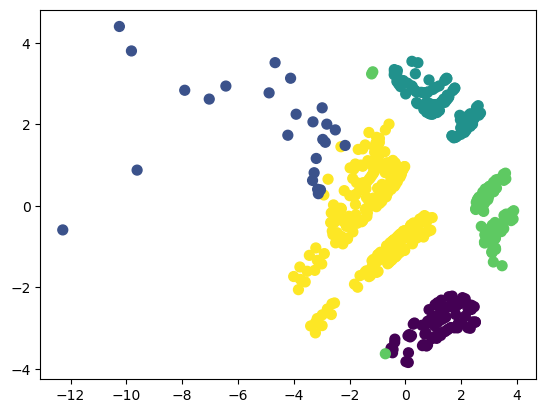

The best number of clusters is 0       2
1       2
2       4
3       2
4       2
       ..
3088    2
3089    4
3090    2
3091    3
3092    3
Length: 3093, dtype: int32
The Sillhouette score for the best clustering is 0.3707045563128384


In [24]:
#K-MEANS Clustering

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#Estimated Eps = 6

best_clustering = (None, None)
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i)
    k_labels = kmeans.fit_predict(df_data) #npArray
    s_score = silhouette_score(df_data, k_labels)
    if best_clustering[1] == None:
        best_clustering = (pd.Series(k_labels), s_score)
    elif s_score >= best_clustering[1]:
        best_clustering = (pd.Series(k_labels), s_score) 
          
scatter(df_data, best_clustering[0])
print("The best number of clusters is", best_clustering[0])
print("The Sillhouette score for the best clustering is", best_clustering[1])

In [25]:
# your code goes here
df_data = pd.get_dummies(df, columns= ["SURFACE", "SITE_NAME"])
df_data.drop(["SAMPLE_DATA_NAME", "PARAMETER", "SAMPLE_DATE"], axis=1, inplace=True)
data_Y = df_data["RESULT"].ravel()
data_X = df_data.drop(['RESULT'], axis =1)
print(data_Y.shape)
print(data_X.shape)
data_X.head()


(3093,)
(3093, 13)


,SALAMANDERS,SIZE,DISSOLVED_OXYGEN,YEAR,SURFACE_COBBLE/BOULDER,SURFACE_EXPOSED SUBSTRATE,SURFACE_LEAF LITTER,SURFACE_VEGETATION/MOSS,SITE_NAME_Barton Spring,SITE_NAME_Eliza Spring,SITE_NAME_Old Mill (Sunken Gardens) Spring,SITE_NAME_Old Mill Stream (outflow from Sunken Gardens Pool),SITE_NAME_Upper Barton Spring
6669,1.0,1.0,5.775000,2002,0,0,0,1,0,0,1,0,0
5511,1.0,2.0,6.290000,2002,0,0,0,1,0,1,0,0,0
8097,1.0,1.0,6.101667,2002,1,0,0,0,0,1,0,0,0
8106,1.0,1.0,5.781667,2002,0,0,0,1,0,0,1,0,0
6662,0.0,1.0,5.775000,2002,0,0,0,1,0,0,1,0,0


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size =.2)
print("X_train=",X_train.shape, " y_train=", Y_train.shape)
print("X_test=",X_test.shape, " y_test=", Y_test.shape)

clf = DecisionTreeClassifier(criterion="entropy")
#these are features and labels
clf.fit(X_train, Y_train)
#from sklearn import tree
#tree.plot_tree(clf)

#testing the test data
pred_Y = clf.predict(X_test)

acc = sk.metrics.accuracy_score(Y_test, pred_Y)
print(f"the accuracy is:{acc}")


X_train= (2474, 13)  y_train= (2474,)
X_test= (619, 13)  y_test= (619,)
the accuracy is:0.6252019386106623


For our models, we used cross validaion to tune the hyparemeters for max peth an

In [27]:
#Cross Validaiton: K-MEANS and Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier()

param_dict = {  "max_depth": [5, 10, 15, 20], 
                "min_samples_leaf": [5, 10, 15, 20], 
                "max_features": range(2, 10) }

gscv = GridSearchCV(tree, param_grid=param_dict, cv=5, scoring="accuracy")
gscv = gscv.fit(data_X, data_Y)

print("Best parameters:", gscv.best_params_)
print("Accuracy of best parameters:", gscv.best_score_)

# clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_weight_fraction_leaf=2)
# clf = clf.fit(data_X, data_Y)



/home/user/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 20}
Accuracy of best parameters: 0.6065430723946651


In [28]:
# testing on final model
from sklearn.metrics import accuracy_score

predictions = gscv.predict(data_X)
print("accuracy score", accuracy_score(predictions, data_Y))



accuracy score 0.6624636275460718


In [29]:
data_Y = df_data["SALAMANDERS"].ravel()
data_X = df_data.drop(['SALAMANDERS'], axis =1)

tree = DecisionTreeClassifier()

param_dict = {  "max_depth": [5, 10, 15, 20], 
                "min_samples_leaf": [5, 10, 15, 20], 
                "max_features": range(2, 10) }

gscv = GridSearchCV(tree, param_grid=param_dict, cv=5, scoring="accuracy")
gscv = gscv.fit(data_X, data_Y)

print("Best parameters:", gscv.best_params_)
print("Accuracy of best parameters:", gscv.best_score_)



Best parameters: {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 15}
Accuracy of best parameters: 0.6136194195670018


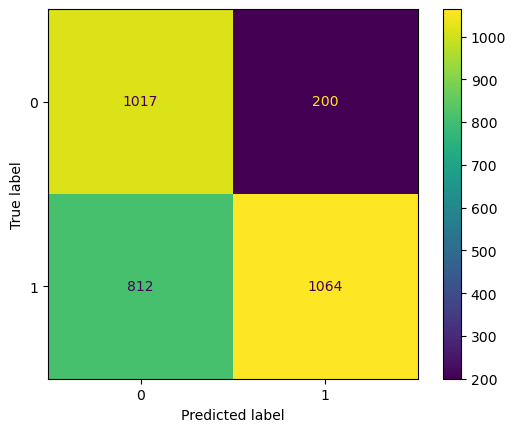

Precision (+): 0.8417721518987342
Precision (-): 0.5560415527610716
Recall (+): 0.5671641791044776
Recall (-): 0.8356614626129828


In [30]:
from sklearn import metrics

# Testing for correctly predicting type of salamander based on given features
predictions = gscv.predict(data_X)

matrix = metrics.confusion_matrix(data_Y, predictions)
plot = metrics.ConfusionMatrixDisplay(matrix)
plot.plot()
plt.show()

tn, fp, fn, tp = matrix.ravel()
tpr = np.diag(matrix)
# print("True Positive Rate:", tpr)

print("Precision (+):", tp / (tp + fp))
print("Precision (-):", tn / (tn + fn))
print("Recall (+):", tp / (tp + fn))
print("Recall (-):", tn / (tn + fp))